In [191]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

## Homework #5

*Please edit the cell below to add your full name (first and last) and the full names of any group members that you collaborated with on this assignment.* 

Name:   Kaitlyn Huynh
Group Members:   
***

In [192]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pymc as pm
from scipy.special import expit as logistic
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<!-- BEGIN QUESTION -->

**Question 1**. **(20 points)** The data in *Data/NWOGrants.csv* are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012 (see [van der Lee and Ellemers](https://doi.org/10.1073/pnas.1510159112)).

 These data have a very similar structure to the UC Berkeley Admissions data discussed in lecture. 

* Include an image of a directed acyclic graph (DAG) for this data that represents the relationship between the variables.  **Clearly describe what the nodes in your graph represent**. **Do not include the number of applications** in your DAG or as a predictor in your linear model. 

    **Note** : *Refer to **dag_tutorial.ipynb** for instructions on how to include a DAG in your Jupyter notebook using Python.*

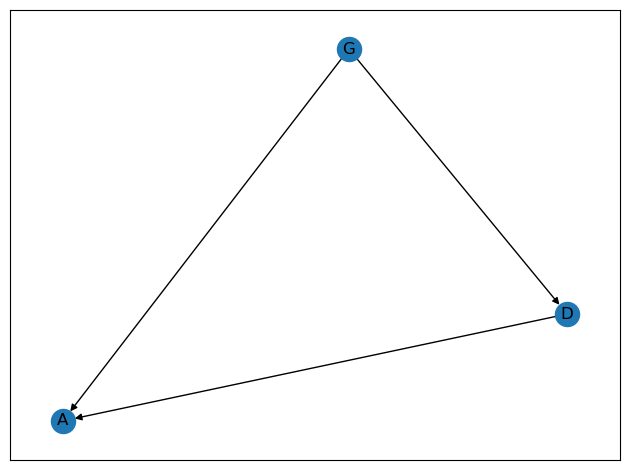

In [193]:
graph = nx.DiGraph()
graph.add_edges_from([("G", "D"), ("D", "A"), ("G", "A")])
nx.draw_networkx(graph, arrows=True)
plt.tight_layout()

There are 3 nodes, "G" for the gender of an individual, "A" for the number of awards an individual gets, and "D" for the discipline the individual is in. G influences A because it is possible that one gender was awarded more than the other based on historical practices. G influences D because it is possible that certain genders tend to favor specific disciplines. D influences A because it is likely that certain disciplines provide varying amounts of opportunity and potential to win awards.

Use a Binomial GLM to estimate the TOTAL causal effect of reported gender on grant awards. 

Notes:  
- You **must provide justification** for the prior distributions used in your model to receive full credit. **Limit your justification to no more than 5 sentences.**
- You can also use logistic regression for your solution but this will require disaggregating the data.

In [194]:
df = pd.read_csv("Data/NWOGrants.csv", header=0)
A = df.awards
N = df.applications
G = np.where(df.gender == "f", 0, 1) # gender
D = pd.Categorical(df.discipline).codes

with pm.Model() as m_GA_total:
    alpha = pm.Normal("alpha", 0, 1, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(alpha[G])) 
    modA = pm.Binomial("A", n=N, p=p, observed=A) 
    idata_GA_total = pm.sample()
az.summary(idata_GA_total, var_names=["~p"], kind="all")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.732,0.081,-1.851,-1.593,0.002,0.001,1904.0,1462.0,1.0
alpha[1],-1.527,0.065,-1.633,-1.423,0.002,0.001,1694.0,1507.0,1.0


"alpha" has a mean of 0 and standard deviation of 1 to reflect that there are no major initial effects from G on A. The gender value is transformed into a probability using logit. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Provide a gender contrast plot and a written interpretation of the plot. **Limit your interpretation of the plot to no more than 3 sentences.**

/tmp/ipykernel_1140/2360435162.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post1 = az.extract_dataset(idata_GA_total)


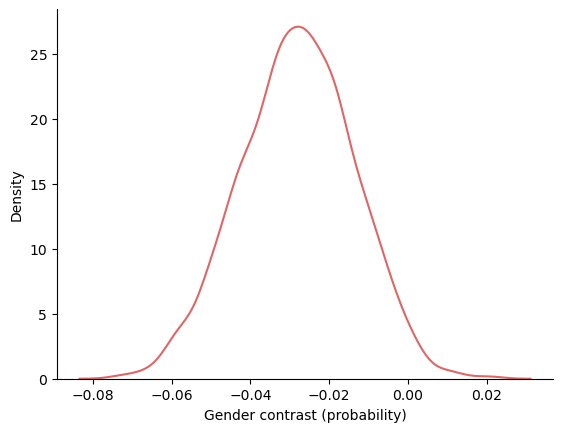

In [195]:
post1 = az.extract_dataset(idata_GA_total) 
probA_G0 = logistic(post1.alpha[0]) # female
probA_G1 = logistic(post1.alpha[1]) # male
diff_prob = probA_G0 - probA_G1 # female - male

sns.kdeplot(diff_prob, color="#e06666")
plt.xlabel("Gender contrast (probability)")
sns.despine()

Males are favored for awards according to this contrast model, since the peak of this curve lies at approx. -0.01. This indicates that the probability for males was larger than females if the difference between (female - male) is negative. The area under the curve from probability 0.00 to 0.02 demonstrate that there are much smaller percentage of differences where female probabilty is greater than male probability, such that the difference is positive. Values of probability beneath the curve from -0.08 to 0.00 have negative differences, where males have a higher probability. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2**. **(22 points)** Now estimate the AVERAGE DIRECT causal effect of gender on grant awards using a counterfactual simulation as demonstrated in lecture.

**Note** : _Refer to the counterfactual simulation for UC Berkeley admission outcomes from the lecture on Bernoulli/Binomial Generalized Linear Models for guidance. Its ok to just write code and generate plots for this question. Question 3 focuses on interpreting your results._

There seems to be an effect of gender on grant awards, based on the summarized data. Each of the averages fall between the HPDI interval. r-hat values are extremely close to 1 suggesting reliable estimates.

In [196]:
# model for counterfactual simulation

with pm.Model() as m_GA_cf:
    # pm.MutableData allow for simulated interventions on variable
    d_G = pm.MutableData("gender", G.astype("int64"))
    d_D = pm.MutableData("discipline", D.astype("int64"))
    d_A = pm.MutableData("awards", A.astype("int64"))
    d_N = pm.MutableData("num", N.astype("int64")) # number of applications
    
    alpha = pm.Normal("alpha", 0, 1, shape=(2, len(np.unique(A))))
    p = pm.Deterministic("p", pm.math.invlogit(alpha[d_G, d_D]))
    mod_A = pm.Binomial("A", d_N, p, observed=A, shape=d_D.shape)
    
    idata_GA_cf = pm.sample()
    
az.summary(idata_GA_cf, var_names="~p", kind="all")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.966,0.327,-1.536,-0.506,0.005,0.004,5263.0,1372.0,1.00
"alpha[0, 1]",-1.709,0.241,-2.083,-1.328,0.003,0.003,5747.0,1336.0,1.00
"alpha[0, 2]",-1.392,0.191,-1.697,-1.090,0.003,0.002,5609.0,1202.0,1.00
"alpha[0, 3]",-1.209,0.256,-1.619,-0.815,0.004,0.003,5327.0,1409.0,1.00
"alpha[0, 4]",-2.012,0.199,-2.290,-1.651,0.003,0.002,5993.0,1442.0,1.00
"alpha[0, 5]",-1.086,0.343,-1.635,-0.537,0.005,0.004,4860.0,1636.0,1.00
"alpha[0, 6]",-0.825,0.593,-1.744,0.121,0.008,0.009,6185.0,1393.0,1.00
"alpha[0, 7]",-2.004,0.144,-2.220,-1.755,0.002,0.001,5703.0,1260.0,1.00
"alpha[0, 8]",-1.235,0.286,-1.714,-0.800,0.004,0.003,5069.0,1545.0,1.00
"alpha[0, 9]",0.019,0.969,-1.579,1.528,0.013,0.025,5137.0,1315.0,1.00


After estimating the average direct causal effect of gender on grant awards:
1. Plot the average direct causal effect as a contrast plot from the results of the counterfactual simulation.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [A]


Sampling: [A]


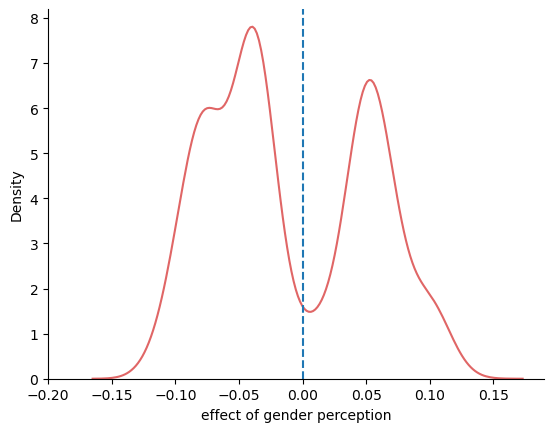

In [197]:
# model for counterfactual simulation
with pm.Model() as m_GA_cf:
# pm.MutableData allow for simulated interventions on variable
    d_D = pm.MutableData("discipline", D.astype("int64"))
    d_G = pm.MutableData("gender", G.astype("int64"))
    d_N = pm.MutableData("num", N.astype("int64"))
    alpha = pm.Normal("alpha", 0, 1, shape=(2, len(np.unique(D)))) # unique disciplines
    p = pm.Deterministic("p", pm.math.invlogit(alpha[d_G, d_D]))
    mod_A = pm.Binomial("A", d_N, p, observed=A, shape=d_D.shape)
    idata_GA_cf = pm.sample()
    
total_apps = df.applications.sum()
apps_per_discipline = df.groupby("discipline")["applications"].sum()

with m_GA_cf: # Female 
# simulate as if all apps from women
    pm.set_data({
         "discipline": np.repeat(range(len(apps_per_discipline)), apps_per_discipline),
         "num": np.repeat(1, total_apps),
         "gender": np.repeat(0, total_apps)
    })
    cf_A_G0 = pm.sample_posterior_predictive(idata_GA_cf)
    
with m_GA_cf:
    pm.set_data({
         "discipline": np.repeat(range(len(apps_per_discipline)), apps_per_discipline),
         "num": np.repeat(1, total_apps),
         "gender": np.repeat(1, total_apps)
    })
    cf_A_G1 = pm.sample_posterior_predictive(idata_GA_cf)
    
# extract the posterior_predictive samples from the Inference Data object to simplify access and merge chains
admitted_G0 = az.extract(cf_A_G0, group="posterior_predictive")
admitted_G1 = az.extract(cf_A_G1, group="posterior_predictive")

# compute admit rate for each simulation by gender
num_samples = admitted_G0.A.values.shape[1]
admit_rate_G0 = admitted_G0.A.values.sum(axis=1) / num_samples
admit_rate_G1 = admitted_G1.A.values.sum(axis=1) / num_samples


# plot contrast
sns.kdeplot(admit_rate_G0 - admit_rate_G1, color="#e06666")
plt.xlabel("effect of gender perception")
plt.xlim(left=-0.2)
plt.axvline(0, linestyle="--")
sns.despine();

2. Plot the DIRECT causal effect of reported gender by discipline, **weighting each discipline** in proportion to the number of applications in the observed data. *Refer to the lecture code for an example of how the thickness of the distribution curves can be determined in proportion to the number of applications*

* **Add a legend** to your plot to label the discipline distributions. You can find documentation for adding a legend to your plot [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html). Specify a `label` each time you plot a contrast distribution and call the `matplotlib.pyplot.legend()` function before displaying the full plot to display the legend.

/tmp/ipykernel_1140/3669619632.py:3: FutureWarning: extract_dataset has been deprecated, please use extract
  my_data = az.extract_dataset(idata_GA_cf)
/tmp/ipykernel_1140/3669619632.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _ = sns.kdeplot(diff_prob_D, linewidth=5 * w[i], label=labels[i])
/tmp/ipykernel_1140/3669619632.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _ = sns.kdeplot(diff_prob_D, linewidth=5 * w[i], label=labels[i])
/tmp/ipykernel_1140/3669619632.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

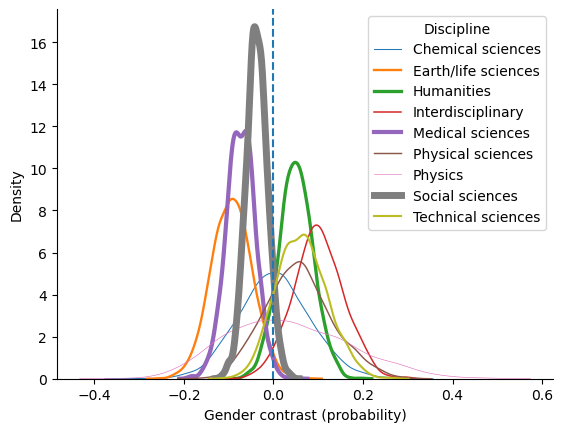

In [198]:
w = apps_per_dept / total_apps
w = w / max(w)
my_data = az.extract_dataset(idata_GA_cf)
probA = logistic(my_data.alpha)
labels = df.groupby("discipline").sum().index.tolist() # store labels

for i in range(len(apps_per_discipline)):
    # gender contrasts by department
    probA_G0_D = probA[0][i]
    probA_G1_D = probA[1][i]
    diff_prob_D = probA_G0_D - probA_G1_D
    _ = sns.kdeplot(diff_prob_D, linewidth=5 * w[i], label=labels[i])

plt.axvline(x=0, linestyle="--")
plt.xlabel("Gender contrast (probability)")
plt.legend(title="Discipline",loc='upper right') # Show labels
sns.despine()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3**. **(8 points)** Considering the total effect (Question 1) and the direct effects (Question 2) of reported gender, what causes seem to contribute to the differences between women and men in award rate in this dataset?

It is not necessary to say whether or not there is evidence of discrimination. Simply explain how the direct effects you have estimated make sense (or not) of the total effect. **Limit your response to no more than 10 sentences.**

There are causes (that aren't specifically known) that can favor females to males and vice versa. The data from total effect reports that more men are favored for awards since the difference in proability (female - male < 0). The direct effects suggest that there is favorability evident for both female and males. In some cases, (female - male > 0) suggesting favorability for females, and others (female - male < 0) suggesting favorability for males. Therefore, we have evidence of bias being in favor of both genders (from the direct effect model) instead of only male as suggested in the total effect model. This makes sense because when you are just analyzing direct effect, it would appear that males are awarded more. However, when analyzing the total effect, which takes any other factors into consideration, the observation that men are awarded more becomes less obvious.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

What explanations might be unaccounted for regarding differences in award outcomes observed in this dataset? As part of your explanation, **provide at least one potential unobserved confound** that might impact the statistical inference performed in this problem. **Limit your response to no more than 3 sentences.**

One confound could be the network that is available to each gender. It is possible men may have more connections in research during the time this data was observed (around 2012). 

In [199]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Before attempting to export your work for submission follow this process: First, make sure you have run all cells in your notebook **in order**. Then, **save your notebook**. Finally, run the export cell below. This sequence of actions will ensure that all code/output/plots appear in the generated PDF. **Only the PDF** will be evaluated for grading purposes.  When executed, the cell below will generate a zip file for you to submit.

In [200]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q3.1 results: All test cases passed!
